In [1]:
import os
import pandas as pd

In [2]:
path = './fashion_mnist'
tr = pd.read_csv(os.path.join(path, 'fashion-mnist_train.csv'))
test = pd.read_csv(os.path.join(path, 'fashion-mnist_test.csv'))

In [14]:
print('train data: ', tr.shape)
print('test data: ', test.shape)

train data:  (11839, 785)
test data:  (10000, 785)


In [15]:
tr.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211.0,220.0,214.0,74.0,0.0,255.0,222.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,12.0,0.0,0.0,40.0,134.0,162.0,191.0,214.0,163.0,146.0,165.0,79.0,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171.0,249.0,207.0,197.0,202.0,45.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22.0,21.0,25.0,69.0,52.0,45.0,74.0,39.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230.0,237.0,229.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0,116.0,112.0,136.0,147.0,144.0,121.0,102.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print('label 종류: ', set(tr['label']))

label 종류:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [23]:
for i in range(10):
    print('Qty of {}: '.format(i), tr['label'].loc[tr['label']==i].count())

Qty of 0:  1200
Qty of 1:  1156
Qty of 2:  1130
Qty of 3:  1199
Qty of 4:  1154
Qty of 5:  1185
Qty of 6:  1214
Qty of 7:  1233
Qty of 8:  1157
Qty of 9:  1211


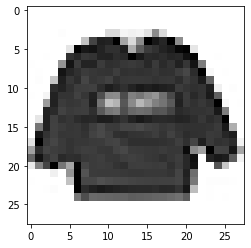

In [94]:
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np

%matplotlib inline
imshow(np.array(tr.iloc[0, 1:]).reshape(28, 28), cmap='Greys')

In [86]:
import torch
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torchvision.transforms as transforms


# Dataset Class
class FashionMnist(Dataset):
    def __init__(self, data_path, is_train=True):
        filename = os.path.join(data_path, 'fashion-mnist_train.csv' if is_train else 'fashion-mnist_test.csv')
        assert os.path.exists(filename), 'File not found error'
        self.is_train = is_train
        self.data = pd.read_csv(filename)
        # self.data = self.data.sort_values(by=['label']).to_numpy
        self.data = self.data.sort_values(by=['label']).to_numpy(dtype=np.float32)
        # self.data_y = self.data[:, 0]
        self.data_y = self.data[:, 0].astype(np.int)
        self.data_x = self.data[:, 1:]
        self.data_shape = (1, 28, 28)
        self.transform = transforms.Compose(
            [
                # transforms.ToPILImage(),
                # transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                # transforms.RandomHorizontalFlip(p=0.5),
                # transforms.RandomVerticalFlip(p=0.5),
                # transforms.RandomRotation(75),
                # transforms.ToTensor()
            ]
        )

    def __len__(self):
        return len(self.data_y)

    def __getitem__(self, index):
        ret_x = np.reshape(self.data_x[index], self.data_shape)
        if self.is_train:  # augmentation
            ret_x = self.transform(ret_x)
        ret_y = self.data_y[index]
        # print(ret_x.shape, ret_y)
        return {'data_x': torch.from_numpy(ret_x), 'data_y': ret_y}



In [87]:
# Model Class
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, tensor):
        return self.block(tensor)


class BasicModel(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(BasicModel, self).__init__()
        k = 32
        self.block = nn.Sequential(
            ConvBlock(in_channel, k),
            ConvBlock(k, k * 2),
            ConvBlock(k * 2, k * 4),
            ConvBlock(k * 4, k * 2)
        )
        self.linear = nn.Linear(k * 2, num_classes)

    def forward(self, tensor):
        out = self.block(tensor)
        out = out.view(-1, out.size(1))
        return self.linear(out)


In [103]:
def main():
    batch_size = 2056
    epoch = 60
    learning_rate = 1e-3
    in_channel = 1
    num_classes = 10
    betas = (0.5, 0.999)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_dataset = FashionMnist('./fashion_mnist', True)
    valid_dataset = FashionMnist('./fashion_mnist', False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, pin_memory=True, num_workers=4, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, drop_last=False, pin_memory=True, num_workers=4)

    model = BasicModel(in_channel=in_channel, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
    for ep in range(epoch):
        # train
        avg_loss = 0
        avg_acc = 0

        count = 0
        for idx, batch in enumerate(train_loader):
            optim.zero_grad()
            batch_x = batch['data_x'].to(device)
            batch_y = batch['data_y'].to(device)
            output = model(batch_x)

            loss = criterion(output, batch_y)
            avg_loss += loss.item()

            # cal accuracy
            _, index = torch.max(output, 1)
            avg_acc += (index == batch_y).sum().float() / len(batch_y)
            count += 1

            loss.backward()
            optim.step()

        avg_loss /= count
        avg_acc /= count

        # valid


        with torch.no_grad(): ## 계산 빨리하기
            avg_test_loss = 0
            avg_test_acc = 0

            count = 0
            for idx, batch in enumerate(valid_loader):
                optim.zero_grad()
                batch_x = batch['data_x'].to(device)
                batch_y = batch['data_y'].to(device)
                model = model.eval()
                output = model(batch_x)

                loss = criterion(output, batch_y)
                avg_test_loss += loss.item()

                # cal accuracy
                _, index = torch.max(output, 1)
                avg_test_acc += (index == batch_y).sum().float() / len(batch_y)
                count += 1

            avg_test_loss /= count
            avg_test_acc /= count

            print("[Epoch:%03d] train loss: %.5f train accuracy: %.4f | valid loss: %.5f valid accuracy: %.4f"
                % (ep + 1, avg_loss, avg_acc, avg_test_loss, avg_test_acc))
            
        ep_list.append(ep + 1)
        tr_loss_list.append(avg_loss)
        tr_acc_list.append(avg_acc)
        valid_loss_list.append(avg_test_loss)
        valid_acc_list.append(avg_test_acc)

    print("Training Done.")


if __name__ == "__main__":
    ep_list = []
    tr_loss_list = []
    tr_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    main()

[Epoch:001] train loss: 0.73044 train accuracy: 0.7689 | valid loss: 0.53293 valid accuracy: 0.8452
[Epoch:002] train loss: 1.13023 train accuracy: 0.6810 | valid loss: 0.51413 valid accuracy: 0.8127
[Epoch:003] train loss: 0.45914 train accuracy: 0.8334 | valid loss: 0.61019 valid accuracy: 0.7566
[Epoch:004] train loss: 0.40978 train accuracy: 0.8527 | valid loss: 0.39109 valid accuracy: 0.8569
[Epoch:005] train loss: 0.37237 train accuracy: 0.8653 | valid loss: 0.33528 valid accuracy: 0.8776
[Epoch:006] train loss: 0.32695 train accuracy: 0.8796 | valid loss: 0.37137 valid accuracy: 0.8632
[Epoch:007] train loss: 0.31050 train accuracy: 0.8859 | valid loss: 0.31880 valid accuracy: 0.8804
[Epoch:008] train loss: 0.29094 train accuracy: 0.8933 | valid loss: 0.31190 valid accuracy: 0.8891
[Epoch:009] train loss: 0.27919 train accuracy: 0.8968 | valid loss: 0.29404 valid accuracy: 0.8936
[Epoch:010] train loss: 0.27126 train accuracy: 0.9013 | valid loss: 0.29373 valid accuracy: 0.8931


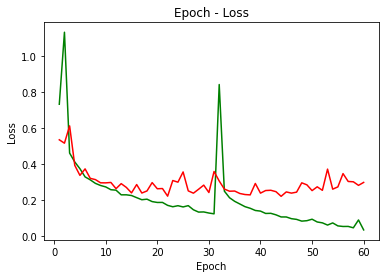

In [108]:
import matplotlib.pyplot as plt
plt.cla()
plt.plot(ep_list, tr_loss_list, 'g')
plt.plot(ep_list, valid_loss_list, 'r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch - Loss")
plt.show()

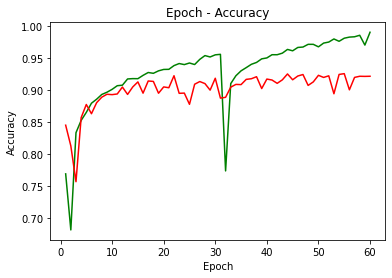

In [109]:
plt.cla()
plt.plot(ep_list, tr_acc_list, 'g')
plt.plot(ep_list, valid_acc_list, 'r')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch - Accuracy")
plt.show()